In [ ]:
# Import pandas for data handling
import pandas as pd

# Load the dataset
Loan_Csv = "https://raw.githubusercontent.com/devShyam9/CS4372_HW2_Shyam_Rudy/refs/heads/main/Loan.csv"

df = pd.read_csv(Loan_Csv)
df.head()


,ApplicationDate,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,...,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,2018-01-01,45,39948,617,Employed,Master,22,13152,48,Married,...,3329.000000,0.724972,11,126928,0.199652,0.227590,419.805992,0.181077,0,49.0
1,2018-01-02,38,39709,628,Employed,Associate,15,26045,48,Single,...,3309.083333,0.935132,3,43609,0.207045,0.201077,794.054238,0.389852,0,52.0
2,2018-01-03,47,40724,570,Employed,Bachelor,26,17627,36,Married,...,3393.666667,0.872241,6,5205,0.217627,0.212548,666.406688,0.462157,0,52.0
3,2018-01-04,58,69084,545,Employed,High School,34,37898,96,Single,...,5757.000000,0.896155,5,99452,0.300398,0.300911,1047.506980,0.313098,0,54.0
4,2018-01-05,37,103264,594,Employed,Associate,17,9184,36,Married,...,8605.333333,0.941369,5,227019,0.197184,0.175990,330.179140,0.070210,1,36.0


In [ ]:
# Check basic info about the dataset
print(df.shape)
print(df.info())
print(df.isnull().sum())

# Check how balanced the target variable (LoanApproved) is
print(df["LoanApproved"].value_counts())
print(df["LoanApproved"].value_counts(normalize=True))


(20000, 36)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ApplicationDate             20000 non-null  object 
 1   Age                         20000 non-null  int64  
 2   AnnualIncome                20000 non-null  int64  
 3   CreditScore                 20000 non-null  int64  
 4   EmploymentStatus            20000 non-null  object 
 5   EducationLevel              20000 non-null  object 
 6   Experience                  20000 non-null  int64  
 7   LoanAmount                  20000 non-null  int64  
 8   LoanDuration                20000 non-null  int64  
 9   MaritalStatus               20000 non-null  object 
 10  NumberOfDependents          20000 non-null  int64  
 11  HomeOwnershipStatus         20000 non-null  object 
 12  MonthlyDebtPayments         20000 non-null  int64  
 13  CreditCardUtilizati

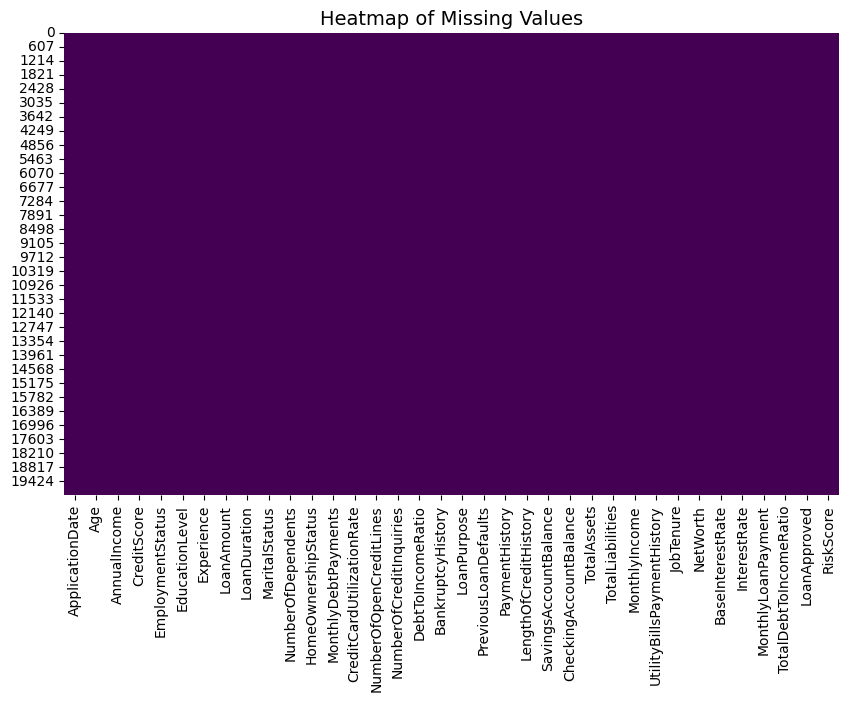

In [ ]:
# Visualize missing values to double-check data completeness
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")  # yellow spots would indicate missing data
plt.title("Heatmap of Missing Values", fontsize=14)
plt.show()


In [ ]:
# Drop ID-like / non-predictive
df = df.drop(columns=["ApplicationDate", "RiskScore"])

# Define X, y
X = df.drop(columns=["LoanApproved"])
y = df["LoanApproved"]

# One-hot encode categoricals
X = pd.get_dummies(X, drop_first=True)

print(X.shape)
print(y.shape)

(20000, 44)
(20000,)


In [ ]:
# Split the data into training and test sets (70% train, 30% test)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Initialize the Decision Tree model
dt = DecisionTreeClassifier(random_state=42, class_weight="balanced")

# Train the model on the training set
dt.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dt.predict(X_test)

# Get predicted probabilities for ROC-AUC calculation
y_proba = dt.predict_proba(X_test)[:, 1]

# Evaluate performance
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


Confusion Matrix:
 [[4245  321]
 [ 349 1085]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9240    0.9297    0.9269      4566
           1     0.7717    0.7566    0.7641      1434

    accuracy                         0.8883      6000
   macro avg     0.8479    0.8432    0.8455      6000
weighted avg     0.8876    0.8883    0.8880      6000

ROC AUC: 0.8431612958798615


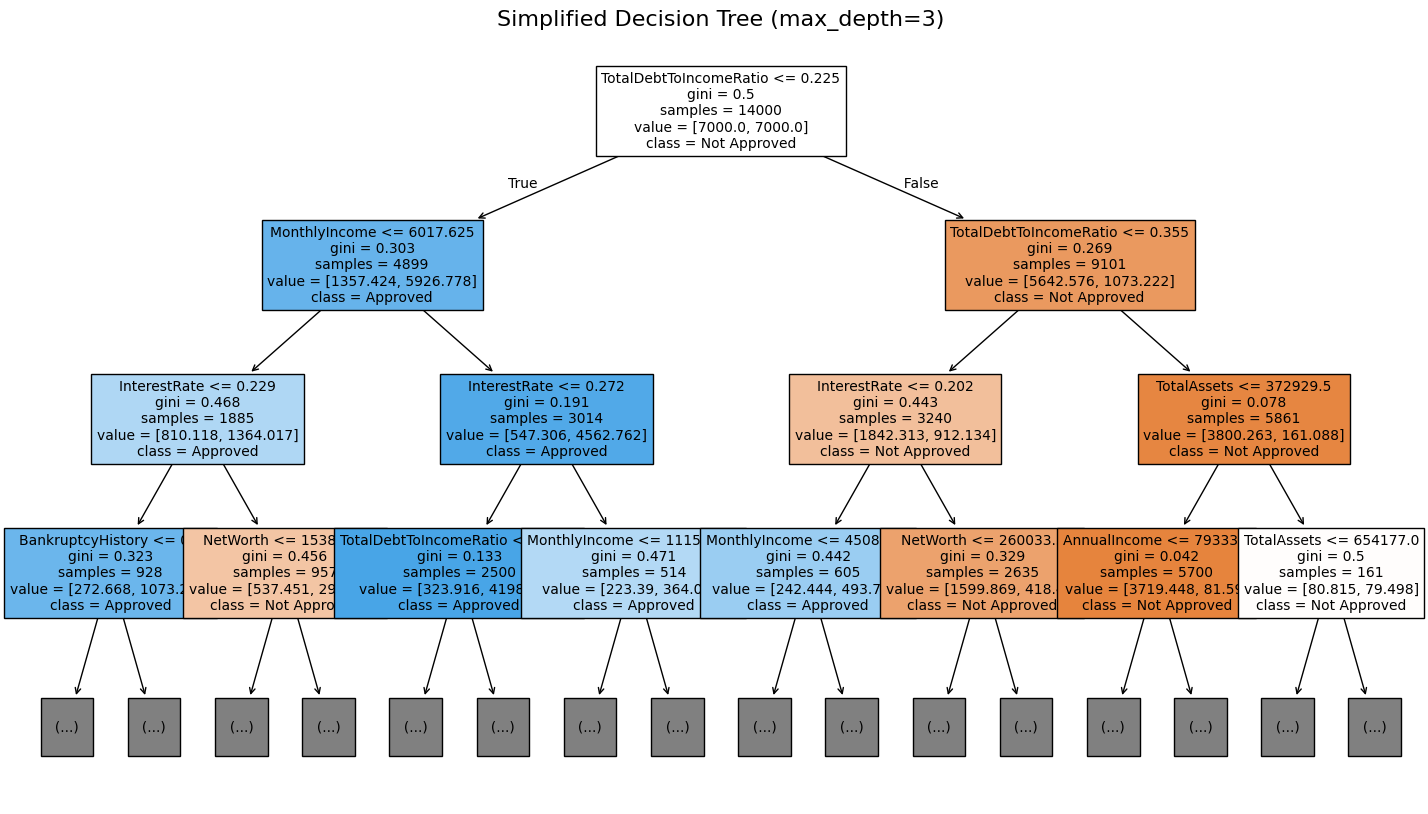

In [ ]:
from sklearn import tree
import matplotlib.pyplot as plt

# Visualize a simplified version of the Decision Tree
plt.figure(figsize=(18,10))
tree.plot_tree(
    dt,
    feature_names=X.columns,
    class_names=["Not Approved", "Approved"],
    filled=True,
    max_depth=3,
    fontsize=10
)
plt.title("Simplified Decision Tree (max_depth=3)", fontsize=16)
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV

# Set up the parameter grid for tuning the Decision Tree
param_grid = {
    "max_depth": [5, 10, 20, None],
    "min_samples_split": [2, 10, 50],
    "min_samples_leaf": [1, 10, 20],
    "criterion": ["gini", "entropy"]
}

# Use GridSearchCV to find the best hyperparameters
grid_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1
)

# Train the model using grid search
grid_dt.fit(X_train, y_train)

# Print the best parameters and corresponding F1 score
print("Best Params:", grid_dt.best_params_)
print("Best F1 Score:", grid_dt.best_score_)

# Evaluate the best-tuned model on the test set
best_dt = grid_dt.best_estimator_
y_pred = best_dt.predict(X_test)
y_proba = best_dt.predict_proba(X_test)[:, 1]

# Display evaluation metrics
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


Best Params: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 10, 'min_samples_split': 2}
Best F1 Score: 0.7896429610818841

Confusion Matrix:
 [[4090  476]
 [ 179 1255]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9581    0.8958    0.9259      4566
           1     0.7250    0.8752    0.7930      1434

    accuracy                         0.8908      6000
   macro avg     0.8415    0.8855    0.8595      6000
weighted avg     0.9024    0.8908    0.8941      6000

ROC AUC: 0.9320896188002892


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np

# Initialize the Random Forest model
rf = RandomForestClassifier(random_state=42, class_weight="balanced", n_jobs=-1)

# Define the parameter distribution for random search
param_dist_rf = {
    "n_estimators": [100, 200, 300],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5, 10],
    "max_features": ["sqrt", "log2", None],
    "bootstrap": [True],
    "criterion": ["gini"]
}

# Use RandomizedSearchCV for faster hyperparameter tuning
rand_rf = RandomizedSearchCV(
    rf,
    param_distributions=param_dist_rf,
    n_iter=20,
    cv=3,
    scoring="f1",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Train the model with the randomized search
rand_rf.fit(X_train, y_train)

# Get the best model and make predictions on the test set
best_rf = rand_rf.best_estimator_
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

# Print the best parameters and evaluation metrics
print("RF Best Params:", rand_rf.best_params_)
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


Fitting 3 folds for each of 20 candidates, totalling 60 fits
RF Best Params: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': None, 'criterion': 'gini', 'bootstrap': True}

Confusion Matrix:
 [[4370  196]
 [ 210 1224]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9541    0.9571    0.9556      4566
           1     0.8620    0.8536    0.8577      1434

    accuracy                         0.9323      6000
   macro avg     0.9081    0.9053    0.9067      6000
weighted avg     0.9321    0.9323    0.9322      6000

ROC AUC: 0.9785593107994266


In [ ]:
# Importing AdaBoost and tools for tuning
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

# Initialize AdaBoost with a fixed random state for reproducibility
ada = AdaBoostClassifier(random_state=42)

# Define the parameter grid — testing different numbers of estimators and learning rates
param_grid_ada = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1, 0.5]
}

# Set up GridSearchCV to find the best combo of parameters
grid_ada = GridSearchCV(
    ada, param_grid_ada, cv=3, scoring="f1", n_jobs=-1, verbose=1
)

# Train (fit) the AdaBoost model with grid search on training data
grid_ada.fit(X_train, y_train)

# Extract the best tuned model from the grid search
best_ada = grid_ada.best_estimator_

# Make predictions on the test set
y_pred = best_ada.predict(X_test)

# Get predicted probabilities for ROC AUC calculation
y_proba = best_ada.predict_proba(X_test)[:, 1]

# Print the best parameters and model evaluation results
print("Ada Best Params:", grid_ada.best_params_)
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Ada Best Params: {'learning_rate': 0.5, 'n_estimators': 300}

Confusion Matrix:
 [[4454  112]
 [ 190 1244]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9591    0.9755    0.9672      4566
           1     0.9174    0.8675    0.8918      1434

    accuracy                         0.9497      6000
   macro avg     0.9382    0.9215    0.9295      6000
weighted avg     0.9491    0.9497    0.9492      6000

ROC AUC: 0.9888642388010099


In [ ]:
from xgboost import XGBClassifier

# Calculate the class imbalance ratio for better weighting
pos = y_train.sum()
neg = (y_train == 0).sum()
spw = neg / pos

# Initialize the XGBoost model
xgb = XGBClassifier(
    random_state=42,
    n_estimators=400,
    tree_method="hist",
    eval_metric="logloss",
    scale_pos_weight=spw,
    n_jobs=-1
)

# Define the parameter distribution for random search
param_dist_xgb = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 3, 5],
    "gamma": [0, 0.5, 1.0]
}

# Randomized search for faster hyperparameter tuning
rand_xgb = RandomizedSearchCV(
    xgb,
    param_dist_xgb,
    n_iter=20,
    cv=3,
    scoring="f1",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Train the XGBoost model with randomized search
rand_xgb.fit(X_train, y_train)

# Get the best tuned model
best_xgb = rand_xgb.best_estimator_

# Make predictions on the test set
y_pred = best_xgb.predict(X_test)
y_proba = best_xgb.predict_proba(X_test)[:, 1]

# Display results
print("XGB Best Params:", rand_xgb.best_params_)
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


Fitting 3 folds for each of 20 candidates, totalling 60 fits
XGB Best Params: {'subsample': 0.9, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 1.0, 'colsample_bytree': 1.0}

Confusion Matrix:
 [[4351  215]
 [  65 1369]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9853    0.9529    0.9688      4566
           1     0.8643    0.9547    0.9072      1434

    accuracy                         0.9533      6000
   macro avg     0.9248    0.9538    0.9380      6000
weighted avg     0.9564    0.9533    0.9541      6000

ROC AUC: 0.9926133736043071


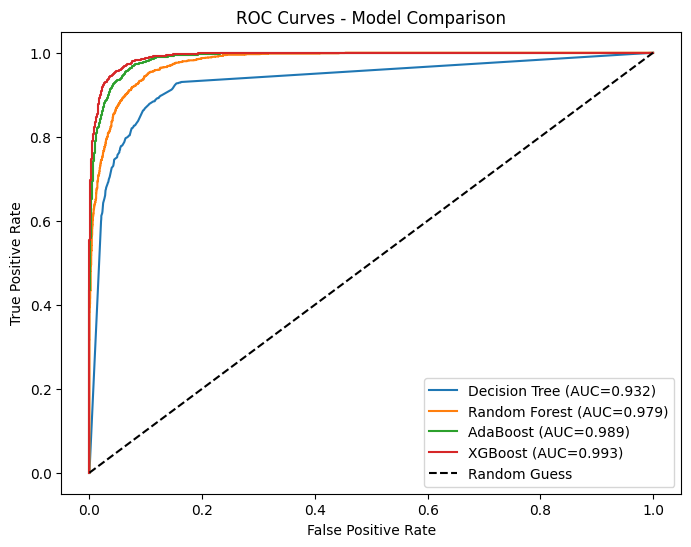

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Store all the tuned models in a dictionary for easy looping
models = {
    "Decision Tree": best_dt,
    "Random Forest": best_rf,
    "AdaBoost": best_ada,
    "XGBoost": best_xgb
}

plt.figure(figsize=(8,6))

# Plot the ROC curve for each model
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

# Add a diagonal line for random guessing (baseline)
plt.plot([0,1], [0,1], 'k--', label="Random Guess")

# Add plot details
plt.title("ROC Curves - Model Comparison", fontsize=14)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


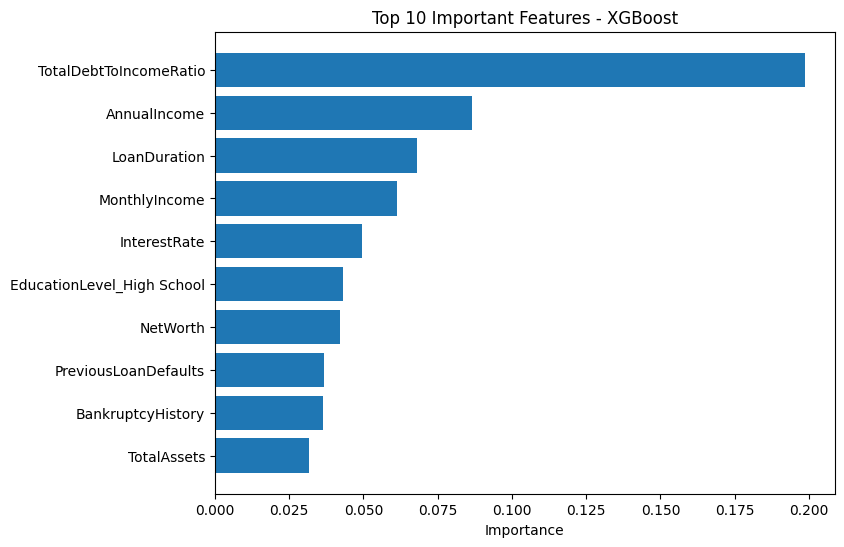

In [ ]:
import pandas as pd
import numpy as np

# Get feature importances from XGBoost
importances = best_xgb.feature_importances_
features = X_train.columns

# Create dataframe
feat_df = pd.DataFrame({"Feature": features, "Importance": importances})
feat_df = feat_df.sort_values(by="Importance", ascending=False).head(10)

# Plot
plt.figure(figsize=(8,6))
plt.barh(feat_df["Feature"], feat_df["Importance"])
plt.gca().invert_yaxis()
plt.title("Top 10 Important Features - XGBoost")
plt.xlabel("Importance")
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Put your fitted models here
models = {
    "Decision Tree": best_dt,
    "Random Forest": best_rf,
    "AdaBoost":      best_ada,
    "XGBoost":       best_xgb
}

def summarize_model(model, X, y_true):
    # predictions
    y_pred = model.predict(X)
    # probabilities if available
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X)[:, 1]
        auc = roc_auc_score(y_true, y_proba)
    else:
        auc = np.nan

    return {
        "Accuracy":  accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall":    recall_score(y_true, y_pred, zero_division=0),
        "F1":        f1_score(y_true, y_pred, zero_division=0),
        "ROC AUC":   auc
    }

# Build the table
rows = {name: summarize_model(model, X_test, y_test) for name, model in models.items()}
results_df = pd.DataFrame(rows).T
results_df = results_df.sort_values("ROC AUC", ascending=False).round(4)

print(results_df)



               Accuracy  Precision  Recall      F1  ROC AUC
XGBoost          0.9533     0.8643  0.9547  0.9072   0.9926
AdaBoost         0.9497     0.9174  0.8675  0.8918   0.9889
Random Forest    0.9323     0.8620  0.8536  0.8577   0.9786
Decision Tree    0.8908     0.7250  0.8752  0.7930   0.9321


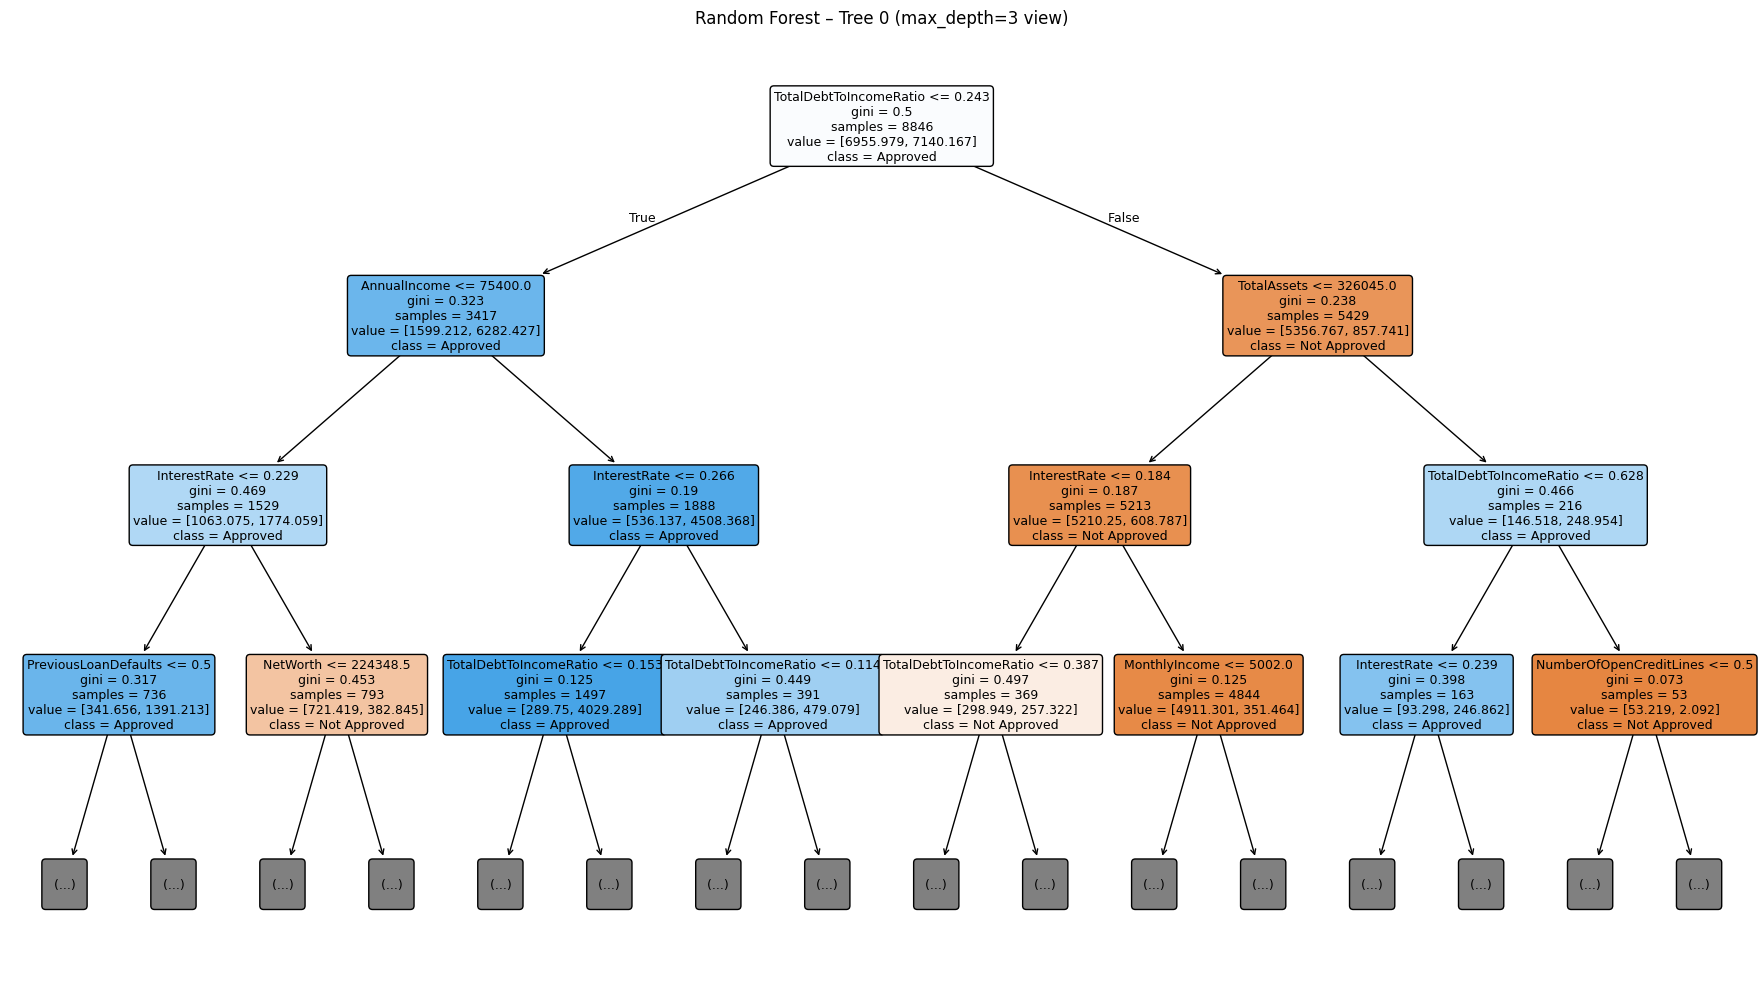

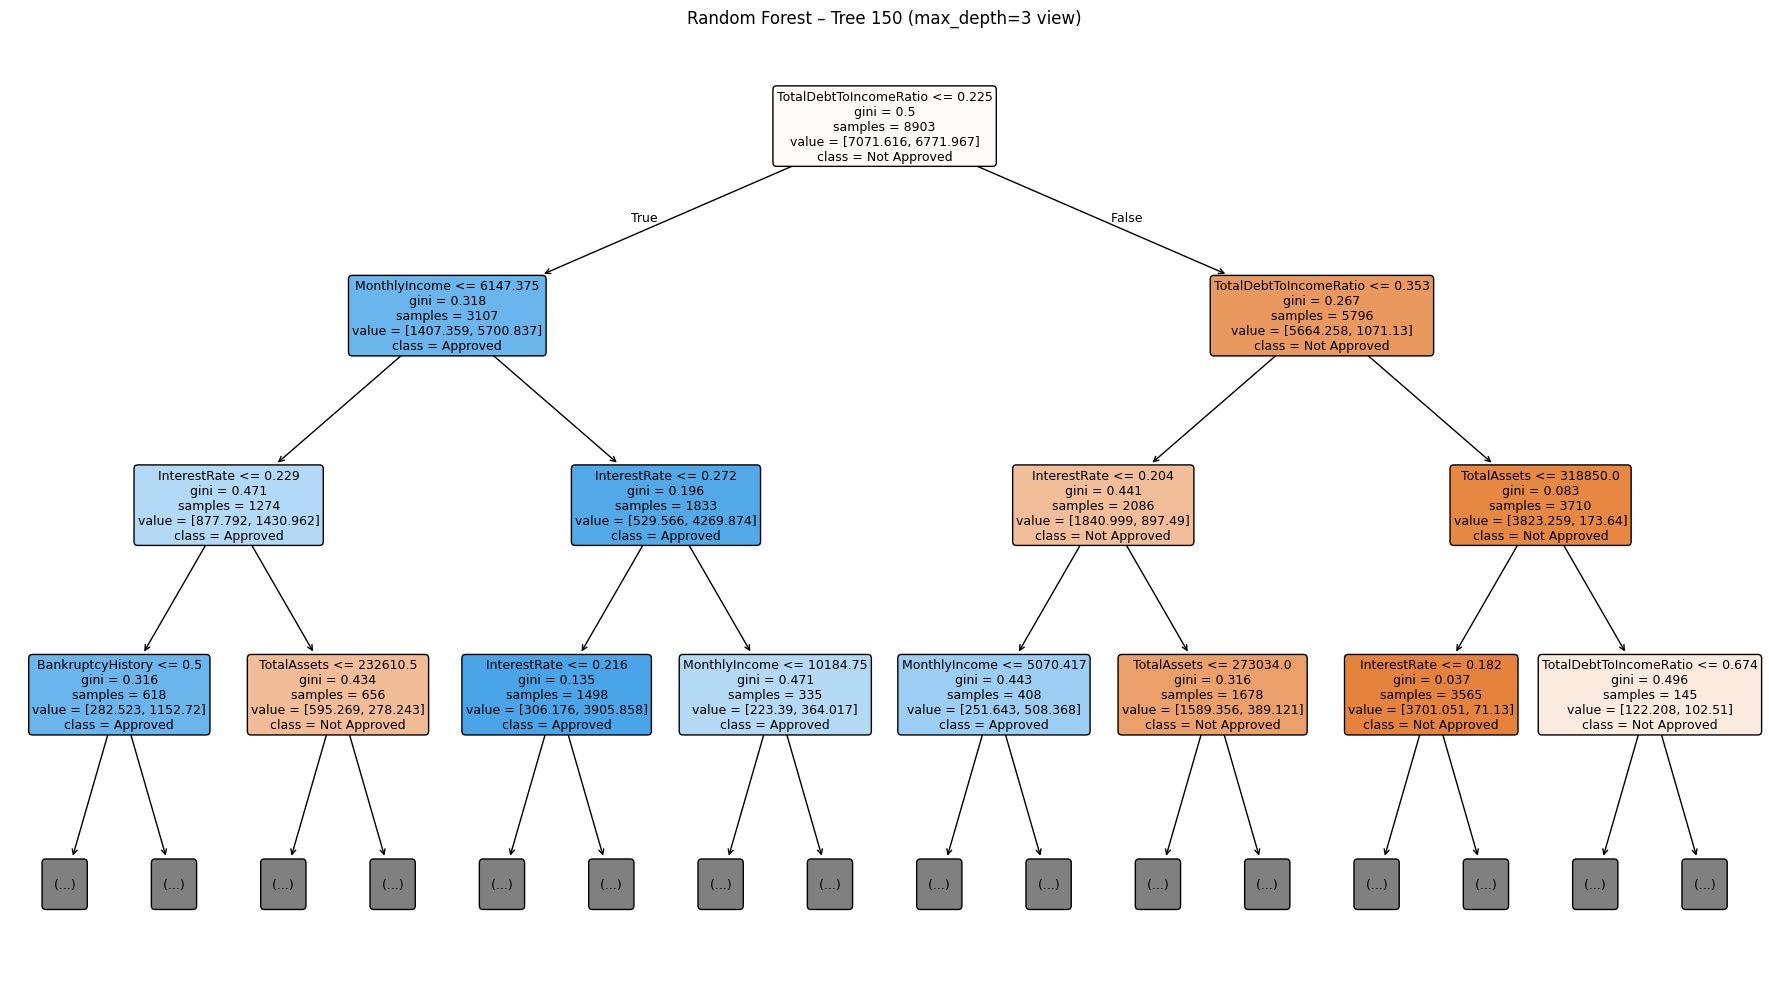

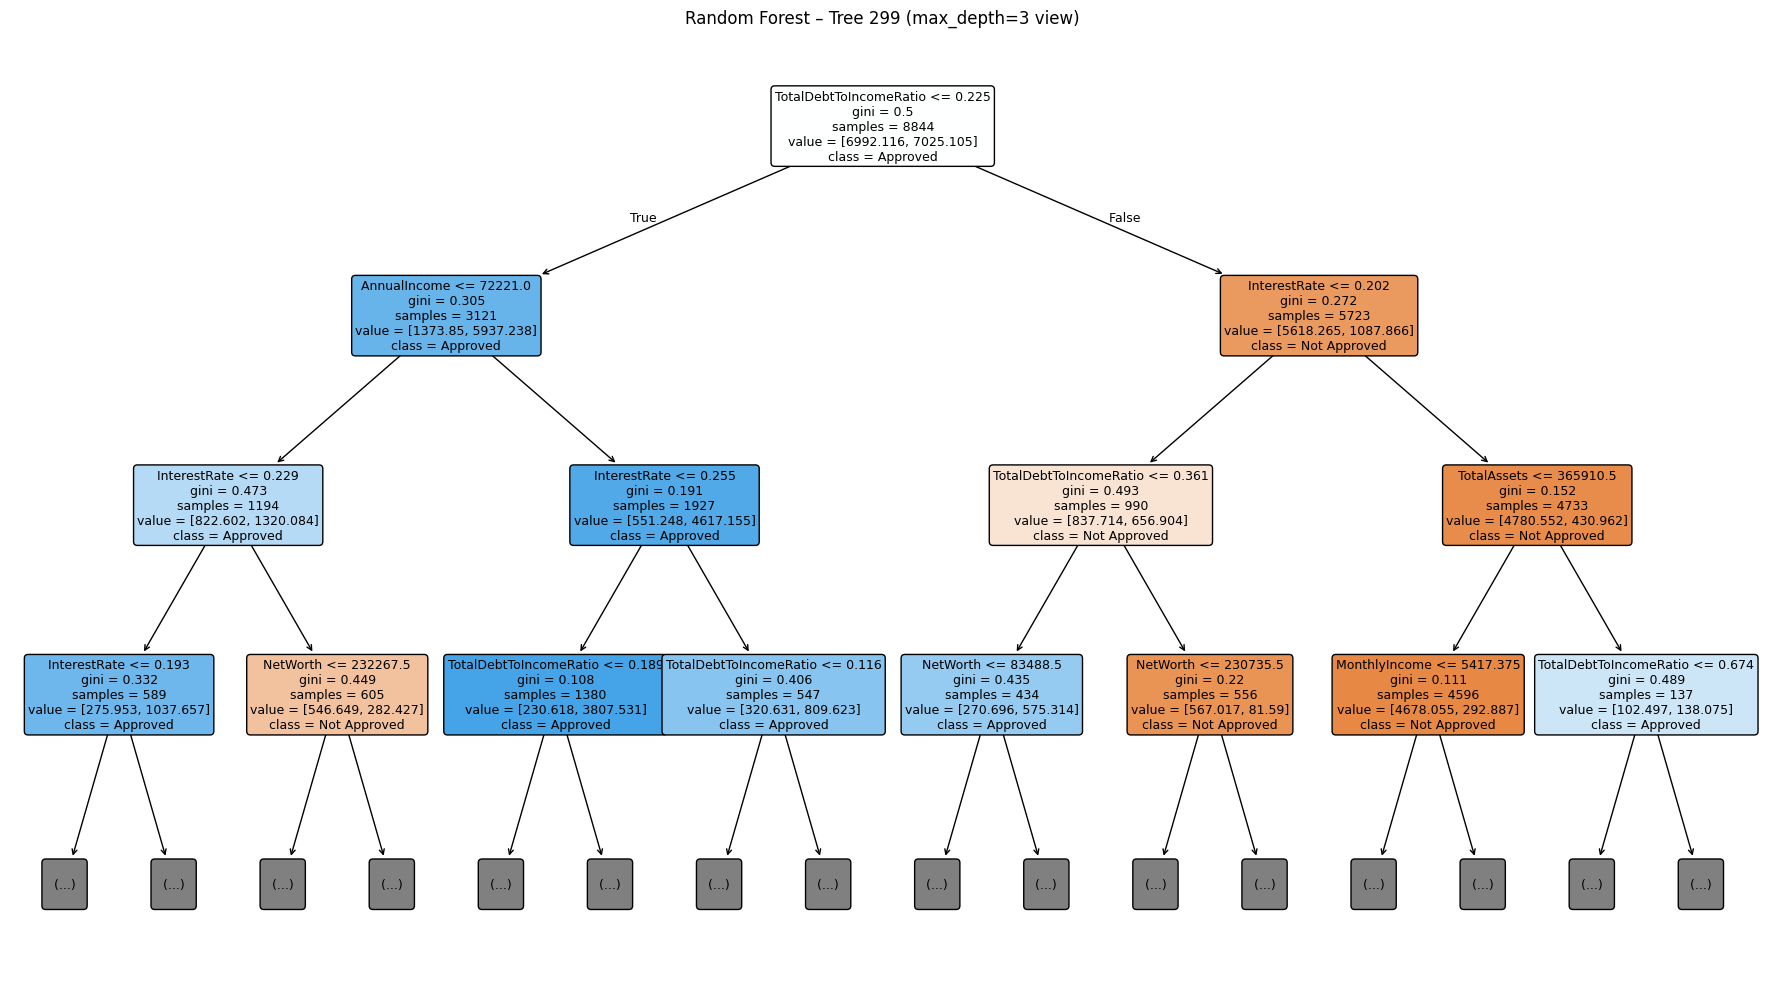

In [ ]:
from sklearn import tree
import matplotlib.pyplot as plt

# Pick three representative trees from the Random Forest:
idxs = [0, len(best_rf.estimators_)//2, len(best_rf.estimators_)-1]

# Loop through and visualize each selected tree
for idx in idxs:
    plt.figure(figsize=(18,10))
    tree.plot_tree(
        best_rf.estimators_[idx],
        feature_names=X_train.columns,
        class_names=['Not Approved', 'Approved'],
        filled=True, rounded=True,
        max_depth=3,
        fontsize=9
    )
    plt.title(f"Random Forest – Tree {idx} (max_depth=3 view)")
    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


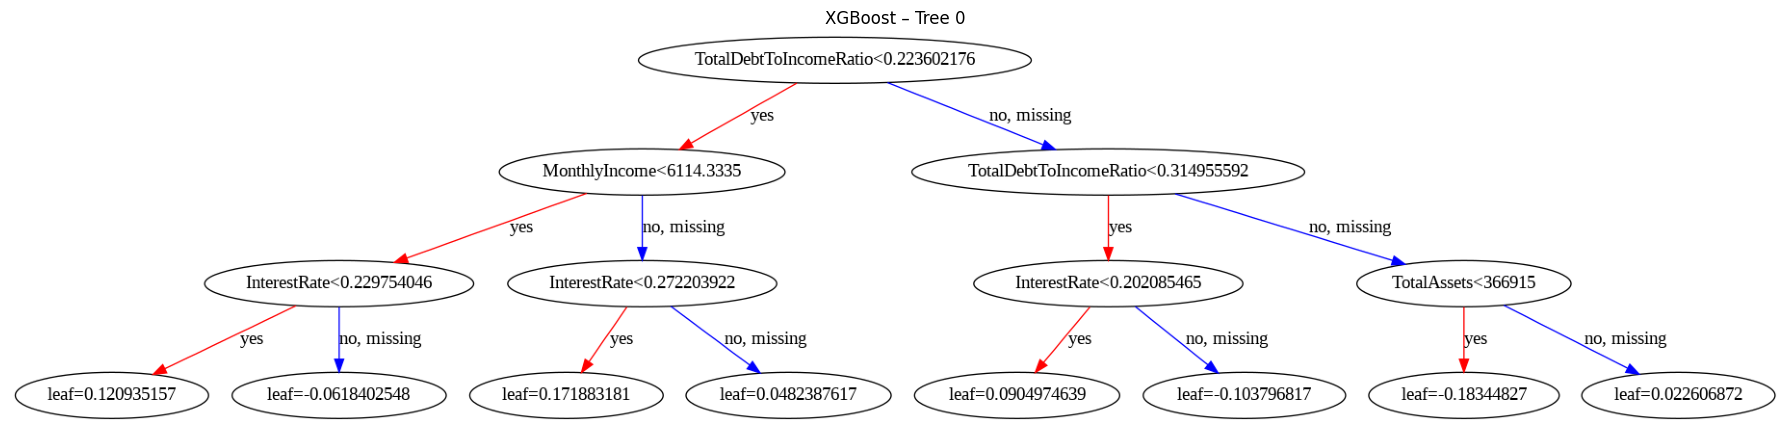

/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


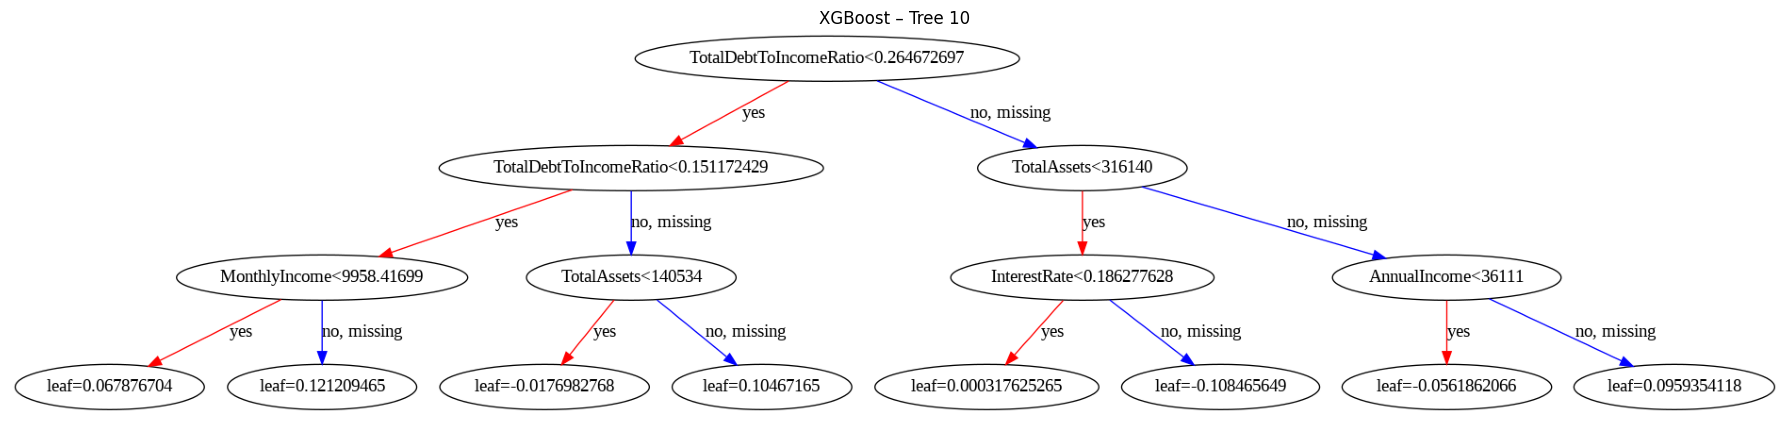

/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


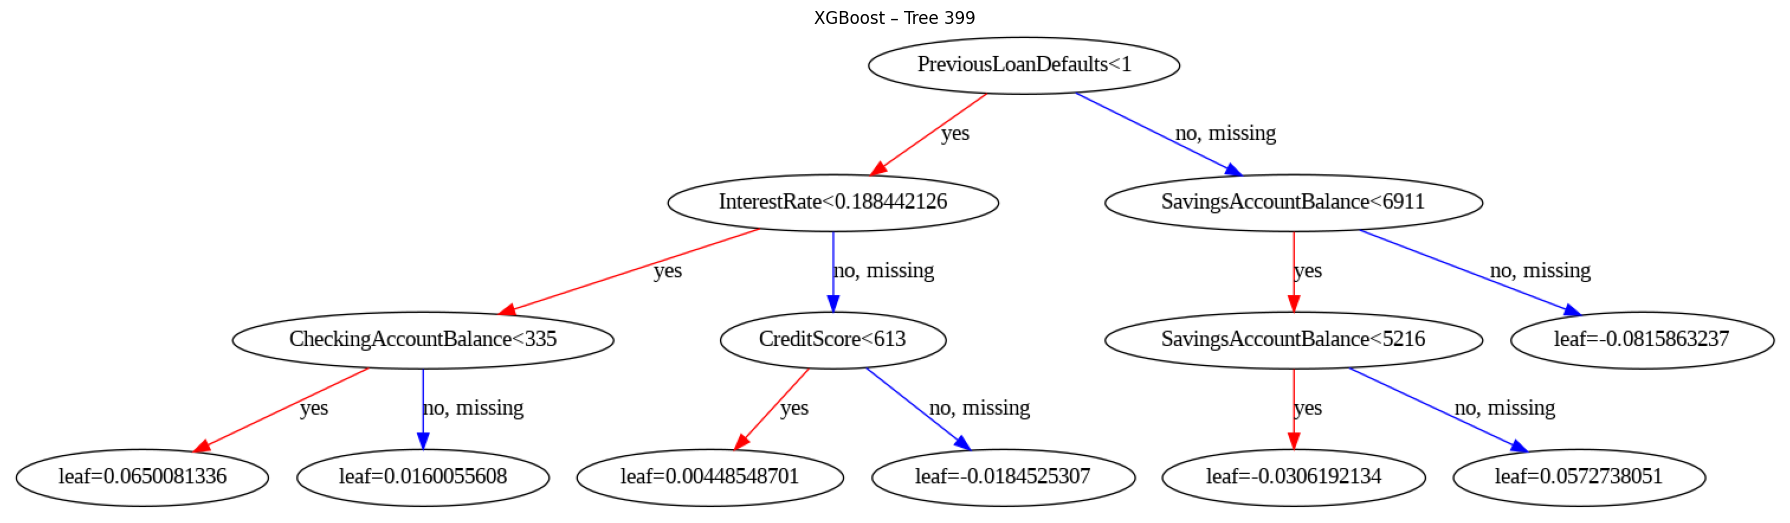

In [ ]:
from xgboost import plot_tree
import matplotlib.pyplot as plt

# Pick three representative trees from the XGBoost model:
idxs = [0, min(10, best_xgb.n_estimators-1), best_xgb.n_estimators-1]

# Loop through and plot each selected tree
for idx in idxs:
    ax = plot_tree(best_xgb, num_trees=idx, rankdir='TB')
    fig = ax.figure
    fig.set_size_inches(18, 10)
    plt.title(f"XGBoost – Tree {idx}")
    plt.tight_layout()
    plt.show()


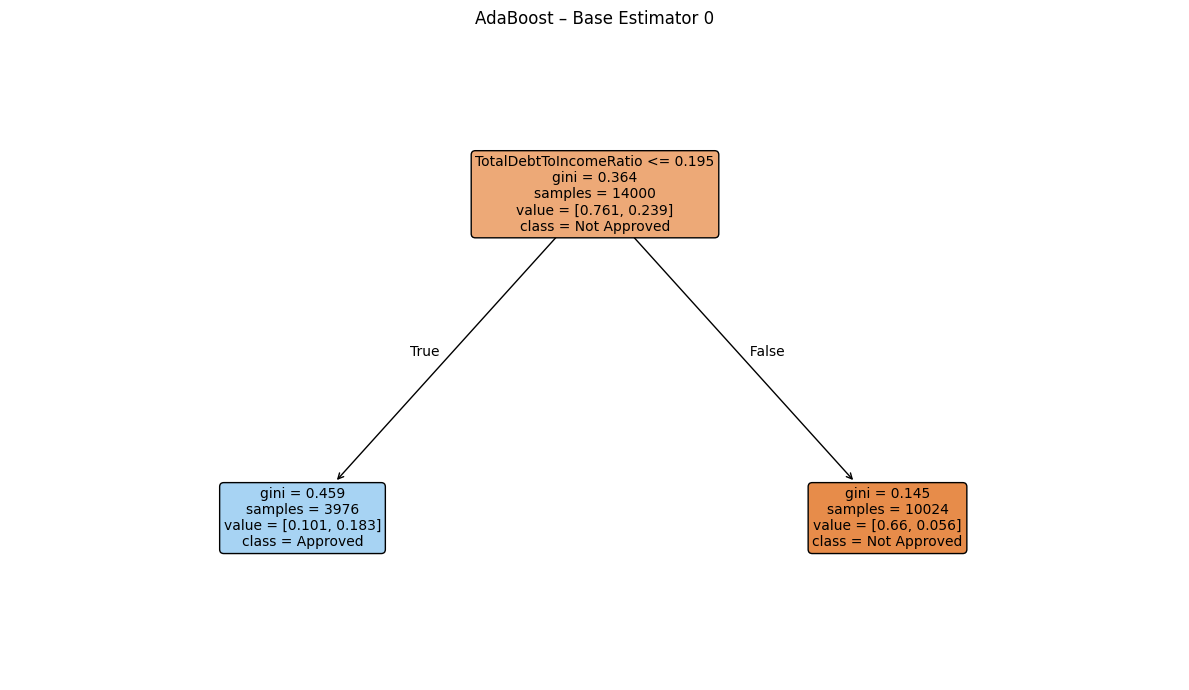

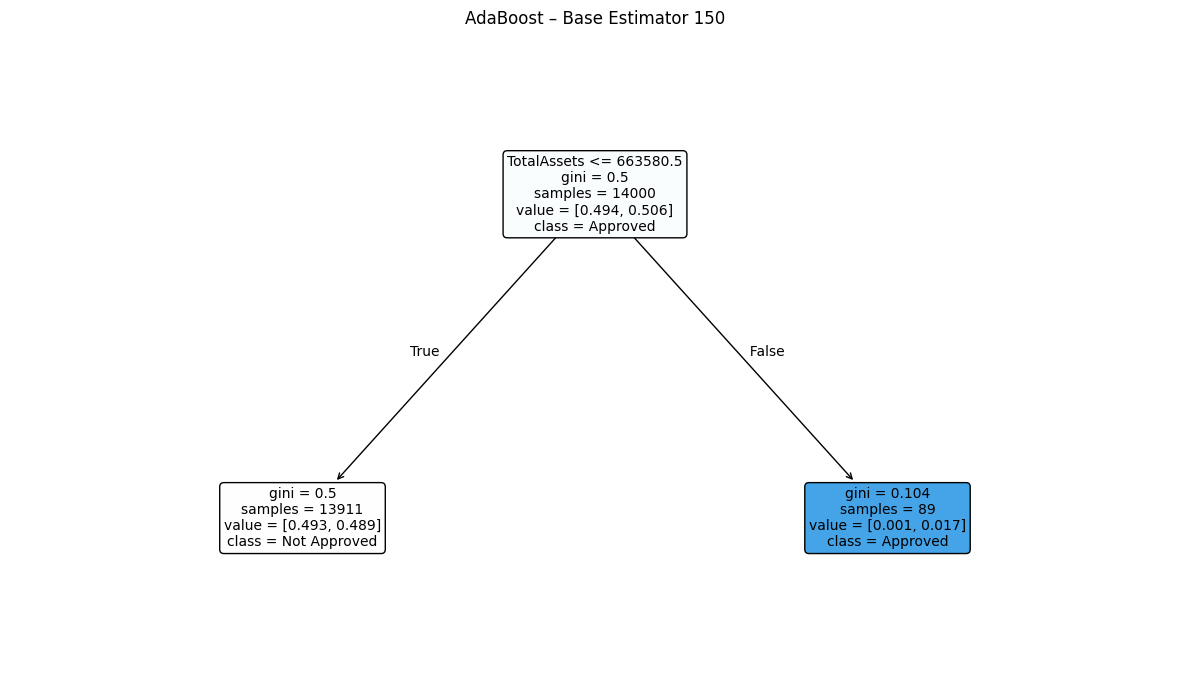

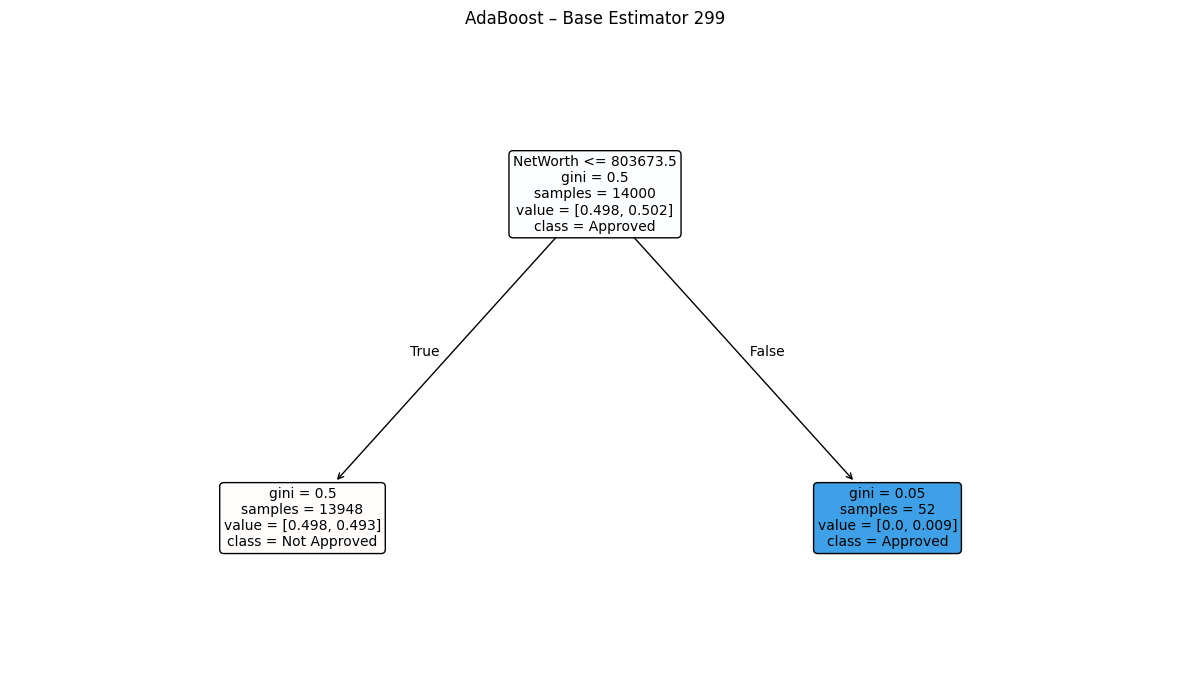

In [ ]:
from sklearn import tree
import matplotlib.pyplot as plt

# AdaBoost keeps a list of base estimators
ada_trees = best_ada.estimators_

# Pick three representative trees: first, middle, and last
idxs = [0, len(ada_trees)//2, len(ada_trees)-1]

# Loop through and visualize each selected base estimator
for idx in idxs:
    plt.figure(figsize=(12,7))
    tree.plot_tree(
        ada_trees[idx],
        feature_names=X_train.columns,
        class_names=['Not Approved', 'Approved'],
        filled=True, rounded=True,
        fontsize=10
    )
    plt.title(f"AdaBoost – Base Estimator {idx}")
    plt.tight_layout()
    plt.show()
